# Muestreador de gibbs



Aplicando un modelo normal (el cual se describe a continuación), donde la información de $θ$ es independiente de $\sigma^2$. Conocido como semi conjugado.

**Distribución muestral:**

$$y_i\mid\theta,\sigma^2 \stackrel{\text{iid}}{\sim}
\textsf{N}(\theta,\sigma^2)\,,\qquad i=1,\ldots,n\,.$$

**Distribución previa:**

\begin{aligned}
  \theta \mid \sigma^{2} & \sim \textsf{N}\left(\mu_{0},
\frac{\sigma^{2}}{\kappa_{0}}\right) \\
  \sigma^{2} & \sim \textsf{GI}\left(\frac{\nu_{0}}{2},
\frac{\nu_{0}\,\sigma_{0}^{2}}{2}\right)
\end{aligned}

El muestreador de **Gibbs** hace uso de la distribución condicional completa. Una vez calculadas estas de manera análitica de procede a aplicar el muestreador de **Gibbs**.

Para el caso normal, las distibuciones condicionales completas son:
- $\theta | - \sim N\left(\frac{\frac{n\bar{y}}{\sigma^2} + \frac{\mu_0}{\tau_0^2}}{\frac{n}{\sigma^2} + \frac{1}{\tau_0^2}}, \frac{n}{\sigma^2} + \frac{1}{\tau_0^2}\right)$
- $\sigma^2 | - \sim GI\left(\frac{\nu_0^2 + n}{2}, \frac{\nu_0^2 + \sum(y_i - \theta)^2}{2}\right)$

En ese sentido el algoritmo para el muestreado de gibbs es:

1. Establezco $(\theta^{(0)}, \sigma^{2^{(0)}})$
2. Dado el estado actual $(\theta^{(b)}, \sigma^{2^{(b)}})$
3. $\theta^{(b+1)} \sim p(\theta | \sigma^{2^{(b)}}, y)$
4. $\sigma^{2^{(b+1)}} \sim p(\sigma^2 | \theta^{(b+1)}, y)$
5. Almaceno $\left(\theta^{(b+1)}, \sigma^{2^{(b+1)}}\right)$

La idea de esto, es obtener realizaciones de la $\theta$ y $\sigma^2$.

## Ejemplo: Muestreado de Gibbs ejemplo normal

W. L. Grogan y W. W. Wirth descubrieron en las selvas de Brasil dos nuevas variedades de un mosquito picador (midge). A un tipo de mosquito lo llamaron mosquito Apf y al otro mosquito Af. Los biólogos descubrieron que el mosquito Apf es portador de una enfermedad debilitante que puede causar la inflamación del cerebro. Aunque la enfermedad rara vez es fatal, la discapacidad causada por la hinchazón puede ser permanente. La otra forma de mosquito, el Af, es inofensiva y un valioso polinizador. En un esfuerzo por distinguir las dos variedades, los biólogos tomaron medidas taxonómicas de los mosquitos que capturaron.

Considere los datos de la longitud del ala en milímetros de n=9
 miembros de la especie Af de mosquitos. A partir de estas nueve mediciones, se quiere hacer inferencia sobre la media poblacional θ
.

Otros estudios sugieren que la longitud de las alas suele ser de alrededor de 1.9 mm con una una desviación estándar de 0.1 mm. Claramente, se tiene que las longitudes deben ser positivas, lo que implica que θ>0
.

Los datos de Grogan y Wirth se encuentran disponibles en la librería Flury de R, pero esta librería no se encuentra disponible para versiones recientes de R.

In [1]:
#Librerías
import pandas as pd # manejo de estructuras de datos
import numpy as np #operaciones
import scipy.stats as stats #estadísticas, distribuciones de probabilidad
import random
import matplotlib.pyplot as plt #Gráficas
import seaborn as sns #Gráficas
from statsmodels.graphics.tsaplots import plot_acf #Gráfico de autocorrelación
import arviz as az #tamaño de muestra efectivo

In [2]:
#Datos
y = [1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08]
n = len(y)

In [3]:
#Estadísticos suficientes
media = np.mean(y)
var = np.var(y)
sumY = np.sum(y)
print(sumY, media, var)

#Hiperparámetros
mu0 = 1.9
tao2 = 0.5**2
nu0 = 1
s20 = 0.01
print(mu0, tao2, nu0, s20)

16.240000000000002 1.8044444444444447 0.015002469135802478
1.9 0.25 1 0.01


Valor inicial, en este caso solo se da un valor incial de $\sigma^2$, dado que solo se necesita este valor, por como está propuesto el algoritmo.

In [4]:
#Número de muestras
B = 100000

#Creamos la matriz en la que guaderemos nuestras simualciones
MC = np.empty((B, 2)) #Matriz vacia de 100000x2
#print(MC.shape) #Dimensión de la matriz
MC = pd.DataFrame(MC, columns=['Theta','Sigma']) #Creando un data frame

#Valor incial
np.random.seed(123)
Isig2 = stats.invgamma.rvs(a = nu0/2, scale = (nu0*tao2)/2, size = 1)


In [5]:
#Algoritmo
np.random.seed(123)
for b in range(1, B + 1):
    #Actualizar theta
    t2n = 1/((n/Isig2) + (1/tao2))
    mun = t2n*((sumY/Isig2) + (mu0/tao2))
    theta = stats.norm.rvs(loc = mun, scale = np.sqrt(t2n), size = 1)
    #Actulizamos sigma^2
    nun = nu0 + n
    s2n = (nu0*var + np.sum((y - theta)**2))/nun
    Isig2 =stats.invgamma.rvs(a = nun/2, scale = (nun*s2n)/2, size = 1)
    MC.iloc[b-1] = [theta, Isig2]


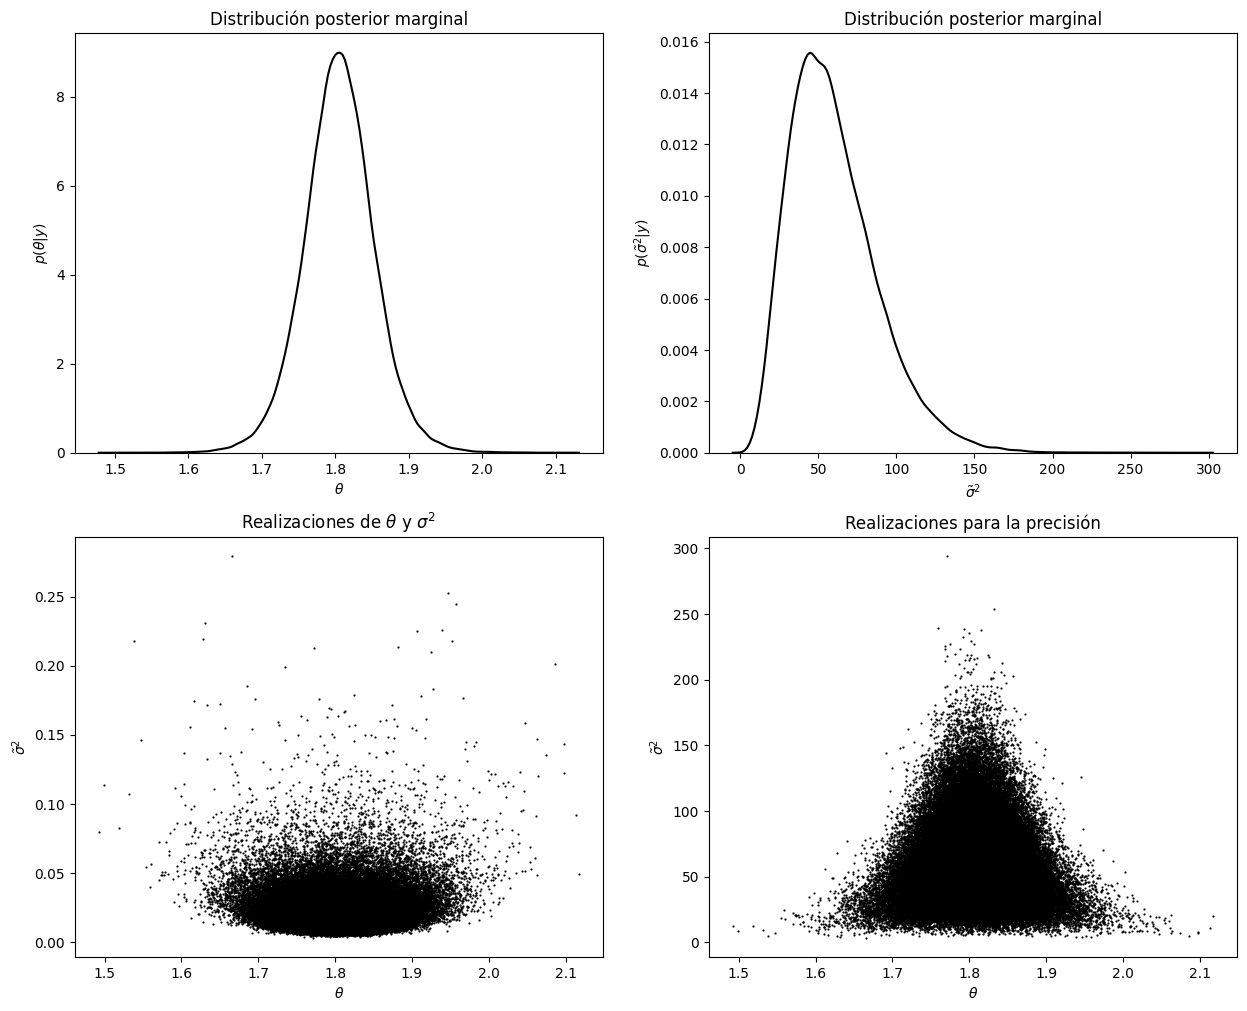

In [7]:
plt.figure(figsize=(15, 12))
plt.subplot(2,2,1) #dos fila dos columnas en la  posición 1
sns.kdeplot(x = MC['Theta'], color = 'black') #kdeplot es para añadir densidad, usa estimación de densidad por kernel
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta | y)$')
plt.title('Distribución posterior marginal')

plt.subplot(2,2,2) # dos fila, dos columnas, en la posición 2
sns.kdeplot(x = 1/MC['Sigma'], color = 'black')
plt.xlabel(r'$\tilde{\sigma}^2$')
plt.ylabel(r'$p(\tilde{\sigma}^2 | y)$')
plt.title('Distribución posterior marginal')

plt.subplot(2,2,3) #dos filas dos columnas en la posición 3
sns.scatterplot(data = MC, x = 'Theta', y = 'Sigma', edgecolor = 'black', facecolor = 'black', s = 2, marker = 'o')
plt.title(r'Realizaciones de $\theta$ y $\sigma^2$')
plt.ylabel(r'$\tilde{\sigma}^2$')
plt.xlabel(r'$\theta$')

plt.subplot(2,2,4) #dos filas dos columnas en la posición 3
sns.scatterplot(x = MC['Theta'], y = 1/MC['Sigma'], marker = 'o', edgecolor = 'black', facecolor = 'black', s=2)
plt.title('Realizaciones para la precisión')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\tilde{\sigma}^{2}$')

#plt.show()
plt.savefig('Gibbs.jpg', bbox_inches='tight')

## Validación de la convergencia

Existe varios métodos, como el gráficos o pruebas directamente. En métodos gráficos tenemos:

1. Gráficas las iteraciones en el ejee x y los valores de los parámetros en el eje y.
2. Gráficas la logverosimilitud evaluada en los parámetros.

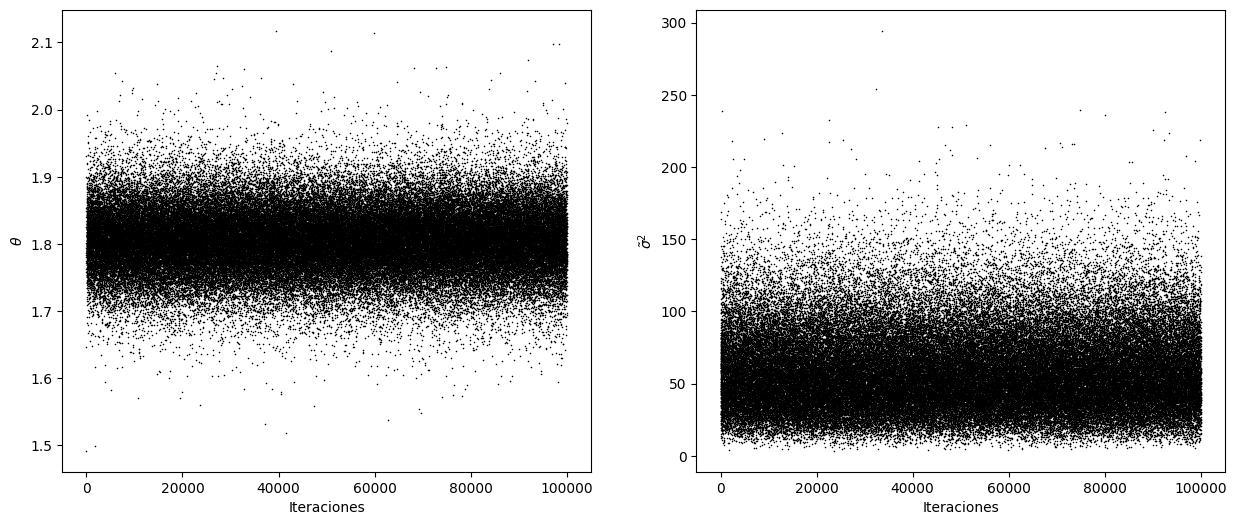

In [ ]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.scatterplot(data = MC, x = range(1,B+1), y = 'Theta', facecolor = 'black', edgecolor = 'black', s = 1)
plt.xlabel('Iteraciones')
plt.ylabel(r'$\theta$')

plt.subplot(1,2,2)
sns.scatterplot(x = range(1,B+1), y = 1/MC['Sigma'],facecolor = 'black', edgecolor = 'black', s = 1)
plt.ylabel(r'$\tilde{\sigma}^2$')
plt.xlabel('Iteraciones')
plt.show()

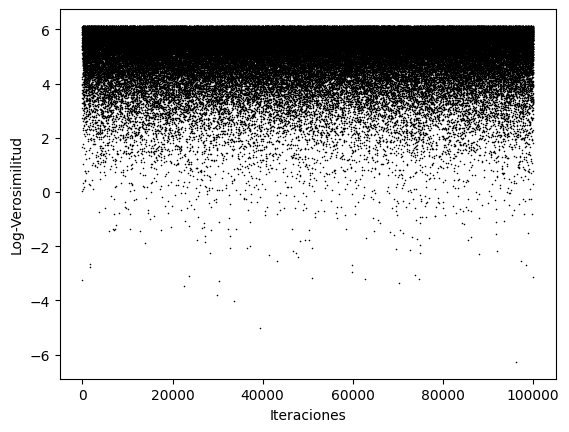

In [12]:
#Graficando la logverosimilitud
LL = np.empty(B)
np.random.seed(123)
for i in range(1, B+1):
    LL[i-1] = np.sum(np.log(stats.norm.pdf(x = y, loc = MC.loc[i-1, 'Theta'], scale = np.sqrt(MC.loc[i-1, 'Sigma']))))

sns.scatterplot(x = range(1, B+1), y = LL, facecolor = 'black', edgecolor = 'black', s = 1)
plt.xlabel('Iteraciones')
plt.ylabel('Log-Verosimilitud')
plt.show()

## Autocorrelación

La autocorrelación se define a continuación:

$\operatorname{acf}_{t}(\theta)=\frac{\frac{1}{B-t}
\sum_{b=1}^{B-t}\left(\theta^{(b)}-\bar{\theta}\right)\left(\theta^{(b+t)}-\bar{\theta}\right)}{\frac{1}{B-1}
\sum_{b=1}^{B}\left(\theta^{(b)}-\bar{\theta}\right)^{2}}$

La idea es que la autocorrelación sea lo más pequeña posible, casi cercana a cero. Ya que si tenemos una correlación muy alta o cercana a 1, tendríamos que no existe información acerca de la dsitribución posterior. Estaríamos haciendo inferencia con un solo datos, un solo valor, no hay manera de hacer inferencia.

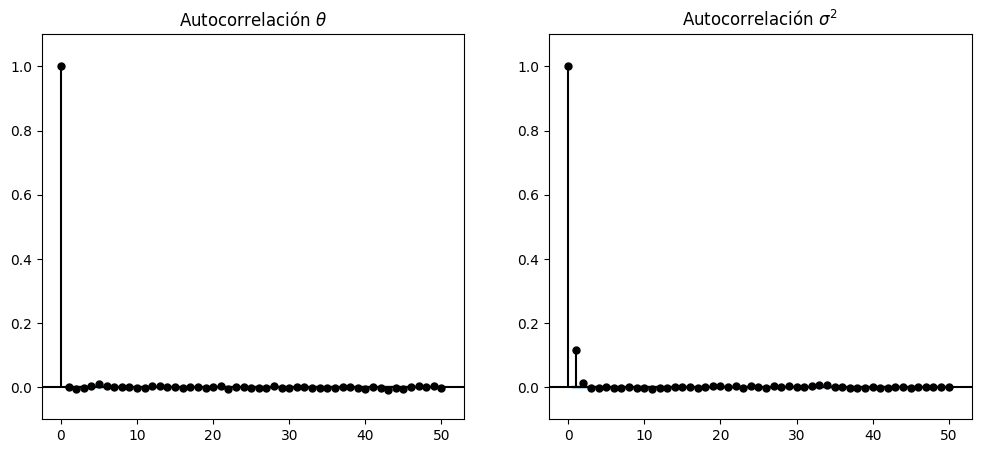

In [ ]:
#Graficos en uno solo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(MC['Theta'], ax  = ax1, color = 'black', adjusted=True, title = r'Autocorrelación $\theta$',  vlines_kwargs={"colors": 'black'})
ax1.set_ylim(bottom = -0.1, top = 1.1)

plot_acf(MC['Sigma'], ax= ax2, color = 'black', adjusted=True, title = r'Autocorrelación $\sigma^2$',  vlines_kwargs={"colors": 'black'})
ax2.set_ylim(bottom = -0.1, top = 1.1)

plt.show()

## Tamaño efectivo de la muestra

El tamaño efectivo de la muestra se define a continuación:

$n_{\text{eff}}(\theta) = \frac{B}{1+2\sum_{t=1}^\infty
\text{acf}_t(\theta)}$

Nótese que el tamaño efectivo depende de la autocorrelación(acf), por lo que es importante tener un autocorrelación lo más pequeña posible para que el tamaño efectivo de la muestra aumente.

In [15]:
#arviz trabaja con formato de datos estilo inferenceData por lo tanto es necesario convertirlo en algo relacionado a eso
df1 = MC['Theta'].to_numpy()
df2 = MC['Sigma'].to_numpy()
ess = [az.ess(df1), az.ess(df2)]
ESS = pd.DataFrame(data = [ess], columns=['Theta', 'Sigma'])
ESS

,Theta,Sigma
0,99966.671931,81992.009251


## Error estandar de monte carlo

Recordar que estamos trabajando sobre la media, por lo que la varianza de la media es $\frac{\sigma^2}{n}$, por lo tanto el devío estandar de la varianza de la media es conocido como el error estandar, por lo que es $\frac{\sigma}{\sqrt{n}}$, lo que nos lleva a que el error estandar de montecarlo es:

$\textsf{EMC}(\hat\theta) =
\frac{\textsf{DE}(\hat\theta)}{\sqrt{n_{\text{eff}}(\theta)}}$

Nótese que EMC depende del tamaño efectivo de la muestra, por lo que es importante aumentar el tamaño de muestra efectivo para que este sea lo más pequeño posible.

Este $\theta$ no hace referencia al parámetro que consideramos en este caso, sino para cualquier parámetro.

In [ ]:
EMC = np.std(MC)/np.sqrt(ESS)
print(EMC)

      Theta     Sigma
0  0.000153  0.000046


In [ ]:
EMC_presc = np.std(1/MC['Sigma'])/np.sqrt(ESS['Sigma']) # Error de montecarlo para la precisión

## Coeficiente de variación de monte carlo

$CV_{MC} = \frac{EMC(\theta)}{|\bar{\theta}|} \cdot 100%$

In [ ]:
CVmc = (EMC/MC.mean())*100
print(CVmc)

      Theta     Sigma
0  0.008466  0.215544


In [ ]:
CVmc_presc = EMC_presc/np.mean(1/MC['Sigma'])*100
print(CVmc_presc)

0    0.163703
Name: Sigma, dtype: float64


Es necesario recordar que para este caso la convergencia se fue casi que inmediata, para otros casos, el tiempo de convergencia se demora por lo que las valores correspondientes a las iteraciones que se necesitaron para la convergencia hay que descartarlas y no usarlas para absoluamente nada.

Si en dado caso se llega a presentar problema de autocorrelación, se aconseja ampliar el número de iteraciones, osea de **B**, y hacer un muestreo sistemático con una amplitud arbitraria, con el fin de corregir la autocorrelación.

*La información presentada precede del curso de estadística Bayesiana dictada por el docente Juan Camilo Sosa del departamento de estadística de la Unnivesidad Nacional de Colombia.*

**REFERENCIAS:**

jstats1702. (2023). *Muestreador de Gibs*. RPubs. https://rpubs.com/jstats1702/944440